# ResNet-50 Fine-Tuning

## Import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import warnings

%matplotlib inline

warnings.filterwarnings('ignore')

2021-11-25 00:00:04.568879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 00:00:04.568953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print('Python Version ' + sys.version)
print('TensorFlow Version ' + tf.__version__)

if int(sys.version[0]) < 3 or int(sys.version[2]) < 7:
    assert("Python version 3.7 or newer is required")
if int(tf.__version__[0]) < 2 or int(tf.__version__[2]) < 3:
    assert("Tensorflow version 2.3 or newer is required")

Python Version 3.9.0 (default, Nov 15 2020, 14:28:56) 
[GCC 7.3.0]
TensorFlow Version 2.6.2


## Set some common parameters

In [3]:
IMAGE_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 100

CUR_PATH = os.path.abspath('')
TRAIN_PATH = CUR_PATH + '/../../../dataset/data/classified'
VALID_PATH = CUR_PATH + '/../../../dataset/data/validation'
TEST_PATH = CUR_PATH + '/../../../dataset/data/test'
SAVE_PATH = CUR_PATH + '/../../models'

os.makedirs(SAVE_PATH, exist_ok=True)

classes = {0 : "Baby",
           1 : "Not Baby"}

## Define a Data Augmentation Proceedure / Function

In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    return image

## Define Data Generators

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          samplewise_center=True,
                                                          samplewise_std_normalization=True,
                                                          preprocessing_function=data_augment)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                   samplewise_center=True,
                                                                   samplewise_std_normalization=True)

val_test_datagen.apply_transform

train_ds = datagen.flow_from_directory(
        directory=TRAIN_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=1,
        color_mode='rgb',
        shuffle=True,
        class_mode='binary')

val_ds = val_test_datagen.flow_from_directory(
        directory=VALID_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        shuffle=True,
        class_mode='binary')

test_ds = val_test_datagen.flow_from_directory(
        directory=TEST_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='binary')

Found 135 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


2021-11-25 00:00:09.154960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-25 00:00:09.155020: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-25 00:00:09.155063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snf-22339): /proc/driver/nvidia/version does not exist
2021-11-25 00:00:09.155578: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)


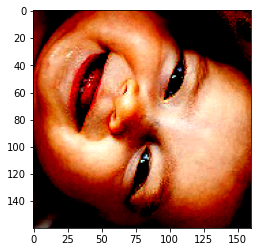

In [6]:
x = train_ds.next()
image = x[0][0]
print(image.shape)
plt.imshow(image)

In [7]:
cat_img = plt.imread(TRAIN_PATH + '/baby/1.jpeg')

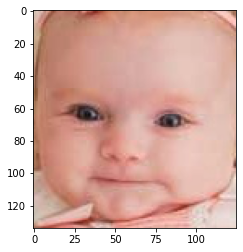

In [8]:
plt.imshow(cat_img)

## Load the default ResNet-50 model

In [9]:
res_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), classes=len(classes)
)

res_model.trainable = False

## Create a custom model

In [10]:
model = tf.keras.Sequential(
    [
        res_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 51200)             204800    
_________________________________________________________________
dense (Dense)                (None, 16)                819216    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 24,611,809
Trainable params: 921,665
Non-trainable params: 23,690,144
______________________________________

## Define Callbacks

In [11]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy'])

STEP_SIZE_TRAIN = train_ds.n // train_ds.batch_size
# STEP_SIZE_VALID = val_ds.n // val_ds.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 # verbose=1,
                                                 factor=0.2,
                                                 patience=10,
                                                 min_delta=1e-4,
                                                 min_lr=1e-6,
                                                 mode='min')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 # verbose=1,
                                                 min_delta=1e-4,
                                                 patience=30,
                                                 mode='min',
                                                 restore_best_weights=True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', 
                                                  # verbose=1, 
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  mode='min',
                                                  filepath='./model_resnet_ft.hdf5')

callbacks = [checkpointer, earlystopping] #reduce_lr earlystopping

## Train the Model

In [12]:
model.fit(x=train_ds,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=val_ds,
          epochs=EPOCHS,
          callbacks=callbacks)

model.save(SAVE_PATH + '/model_resnet_ft.h5')

os.remove('./model_resnet_ft.hdf5')

2021-11-25 00:00:15.209126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
8/8 [==============================] - 9s 521ms/step - loss: 0.6918 - accuracy: 0.5966 - val_loss: 0.7010 - val_accuracy: 0.4839
Epoch 2/100
8/8 [==============================] - 3s 306ms/step - loss: 0.6290 - accuracy: 0.6555 - val_loss: 0.7028 - val_accuracy: 0.5161
Epoch 3/100
8/8 [==============================] - 2s 301ms/step - loss: 0.5999 - accuracy: 0.6953 - val_loss: 0.7096 - val_accuracy: 0.5161
Epoch 4/100
8/8 [==============================] - 3s 305ms/step - loss: 0.5215 - accuracy: 0.7227 - val_loss: 0.7133 - val_accuracy: 0.5161
Epoch 5/100
8/8 [==============================] - 2s 293ms/step - loss: 0.3979 - accuracy: 0.8151 - val_loss: 0.7171 - val_accuracy: 0.5161
Epoch 6/100
8/8 [==============================] - 3s 318ms/step - loss: 0.4352 - accuracy: 0.7899 - val_loss: 0.7199 - val_accuracy: 0.5161
Epoch 7/100
8/8 [==============================] - 2s 285ms/step - loss: 0.3595 - accuracy: 0.8739 - val_loss: 0.7193 - val_accuracy: 0.5161
Epoch 8/100
8

## Evaluate the model on test set

In [13]:
# test_model = tf.keras.models.load_model("model_res_ft.h5")

In [14]:
# test_model.evaluate(test_ds)

In [15]:
model.evaluate(test_ds)

2/2 [==============================] - 1s 73ms/step - loss: 0.2647 - accuracy: 0.8889


[0.264689177274704, 0.8888888955116272]

In [16]:
res = model.predict(test_ds)

In [17]:
res

array([[0.9027099 ],
       [0.9747867 ],
       [0.76348424],
       [0.9864922 ],
       [0.8790315 ],
       [0.7043252 ],
       [0.8847842 ],
       [0.04361701],
       [0.04614815],
       [0.00125766],
       [0.5178174 ],
       [0.4477296 ],
       [0.11206552],
       [0.72924936],
       [0.27361882],
       [0.72121835],
       [0.96028626],
       [0.95940065]], dtype=float32)

In [18]:
res[res >= 0.5] = 1

In [19]:
res[res < 0.5] = 0

In [20]:
res

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)